
## Inter-Subject Correlation and Inter-Subject Functional Correlation 
**V.0.2 - beta, [contributions](#contributions)**


## 1. Overview  <a id="ISC_ISFC_overview"></a>

The functional connectivity methods that we used in past weeks compared time series of BOLD activity to infer how different regions of the brain were interacting. However, BOLD activity contains multiple components ([Figure a](#fig1)):
1. Task-based/stimulus-evoked signal
2. Intrinsic, spontaneous fluctuations in neural activity that are participant specific
3. Scanner or physiological noise

In this notebook, we consider methods for combining data across participants. We will use methods that employ this approach to eliminate idiosyncratic activity and noise when calculating fMRI reliability (intersubject correlation, ISC, [Hasson et al., 2004](https://doi.org/10.1126/science.1089506)) and connectivity (intersubject functional correlation, ISFC, [Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). ISC and ISFC are methods that extend functional connectivity measures across subjects. These procedures help to isolate the signal evoked by the task or stimulus since the only activity coupling that ought to exist between subjects is likely a result of task driven activity.

[Figure b,c](#fig1) shows how ISC differs from functional connectivity: rather than correlating brain regions, which preserve participant-specific noise, ISC correlates between the brains of participants in order to capture only the patterns of brain activity that are shared, rather than what is participant specific. In ISC this correlation is done for every voxel in the brain in order to get a full brain map. [Figure e](#fig1) represents this as the diagonal in which each voxel in subject X is correlated with the 'matched' voxel in subject Y.

Note, if you were to perform ISC between all N participants you would need to perform ISC $ \frac{N(N - 1)}{2} $ times. With 30 participants and an average brain size this could mean you have to perform tens of billions of correlations. This isn't prohibitive but it also makes it harder to interpret since it is unclear which ISC maps to use for each participant. To simplify the computational requirements and the interpretation it is typical for ISC to only compare each individual participant with the average of all other participants.

[Figure d](#fig1) shows ISFC: the correlation of every voxel in a participant with every other voxel in another participant. This is like FCMA except it is between participants rather than within participants. In fact, these analyses use the same computational tricks. ISFC is valuable because it allows us to identify activity coupling in voxels that are not aligned across participants: the off diagonal in [Figure e](#fig1) represents correlations for voxels in different parts of the brain. The computational requirements of this are even higher since we have to do this for every pair of voxels so here it is even more necessary to use the average across participants.

<a id="fig1"></a>![alt text](https://media.springernature.com/m685/nature-assets/ncomms/2016/160718/ncomms12141/images/ncomms12141-f1.jpg)

We will use ISC and ISFC to determine brain regions that respond preferentially to narrative stories, rather than to a random assortment of words, replicating Simony et al., (2016). Furthermore, seed-based connectivity analysis does not show differences between resting state activity, random words, and intact narratives, but ISFC does distinguish between these conditions (Simony et al., 2016). Thus, ISFC shows greater sensitivity to the task than seed-based functional connectivity. 



## Goal of this script
    1. To run intersubject correlation (ISC).
    2. To run intersubject functional correlation (ISFC).  
    3. Use ISFC to determine the network of brain regions that respond preferentially to narrative stimuli.  
 

## Table of Contents

[1. Overview of ISC and ISFC](#ISC_ISFC_overview)  
>[1.1 The ISC-ISFC Workflow](#isc_isfc_wkflow)  

**ISC**
>[2.1 Data file preparation](#data_prep_isc)  
>[2.3 Compute ISC](#isc_compute)  
>[2.4 ISC with statistical tests](#isc_stats)  

**ISFC**
>[3.1 Parcel the data](#isfc_parcel)   
>[3.2 Compute FC and ISFC](#fc_isfc)

**Spatial Correlation**
>[4.1 Spatial inter-subject correlation](#spatial_isc)  

#### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  
>[Novel contribution](#novel)  

## The ISC-ISFC Workflow  <a id="isc_isfc_wkflow"></a>


The following sequence of steps are necessary for successfully running ISC and ISFC using [BrainIAK](http://brainiak.org/). 

1. [**Data Preparation:**](#data_prep_isc) Organize a data directory with fMRI subject data that you want to process. All subjects must be in the same anatomical space for analysis. Also you need to create a whole brain mask.  
        
2. [**Compute ISC:**](#isc_compute)  The ISC function computes correlations across subjects for corresponding voxels in the mask. It uses the `compute_correlation` function in BrainIAK, which is optimized for fast execution (and was used for FCMA in the previous week).

3. [**Permutation Test for ISC:**](#isc_stats) Perform statistical analysis to determine significant correlation values for ISC.

4. [**Compute ISFC:**](#isfc_compute) The ISFC function computes correlations for every voxel in one subject with the every other voxel averaged across subjects.

5. [**Cluster the ISFC results:**](#clust_isfc) Create clusters based on the correlation values. 

6. [**Perform ISFC permutation:**](#perm) Perform permutation tests to determine the significance of the results.

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from isc_standalone import isc, isfc, permutation_isc

import matplotlib.pyplot as plt
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


### 2.1 The "Pieman" data  <a id="dataset"></a>

For this script we will use the "Pieman" dataset from [Simony et al., 2016](https://doi.org/10.1038/ncomms12141). A description of the dataset is as follows:

18 native English speakers were scanned (15 females, ages: 18–31), corresponding to the replication dataset from the Pieman study.

Stimuli for the experiment were generated from a 7 min real life story (["Pie Man", Jim O'Grady](https://www.youtube.com/watch?v=3nZzSUDECLo)) recorded at a live storytelling performance (["The Moth" storytelling event](https://themoth.org/), New York City). Subjects listened to the story from beginning to end (intact condition).
 In addition, subjects listened to scrambled versions of the story, which were generated by dividing the original stimulus into segments of different timescales (paragraphs and words) and then permuting the order of these segments. To generate the scrambled stimuli, the story was segmented manually by identifying the end points of each word and paragraph. Two adjacent short words were assigned to a single segment in cases where we could not separate them. Following segmentation, the intact story was scrambled at two timescales: short—‘words’ (W; 608 words, 0.7±0.5 s each) and long—‘paragraphs’ (P; 11 paragraphs, 38.1±17.6 s each). Laughter and applause were classified as single word events (4.4% of the words). Twelve seconds of neutral music and 3 s of silence preceded, and 15 s of silence followed, each playback in all conditions. These music and silence periods were discarded from all analyses.

More details about the experiment may be accessed in the methods section of the paper.

### 2.2 Data File Preparation <a id="data_prep_isc"></a>


**Loading and preparing the data:**

BrainIAK has methods to efficiently load data. We have used some of these functions in previous notebooks.

> *load_images:* reads data from all subjects in a list that you provide. This is like the function load_images_from_dir but here we specify the names manually. 

> *load_boolean_mask:* Create a binary mask from a brain volume

> *mask_images:* Loads the brain images and masks them with the mask provided

> *image.MaskedMultiSubjectData.from_masked_images:* Creates a list of arrays, with each item in the list corresponding to one subject's data. This data format is accepted by the BrainIAK ISC and ISFC function.

In [2]:
# Set up experiment metadata
pieman2_dir = '/home/NEU480/datasets/Pieman2/'
dir_mask = os.path.join(pieman2_dir, 'masks/')
mask_name = os.path.join(dir_mask, 'avg152T1_gray_3mm.nii.gz')
all_task_names = ['word', 'intact1']
all_task_des = ['word level scramble', 'intact story']
n_subjs_total = 18
group_assignment_dict = {task_name: i for i, task_name in enumerate(all_task_names)}

# Where do you want to store the data
dir_out ='./results/isc/'
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

### Helper functions

We provide helper functions to load the data.

In [3]:
# truncate the number of subjects per condition to make this lab faster... 
upper_limit_n_subjs = 15

def get_file_names(data_dir_, task_name_, verbose = False):
    """
    Parameters
    ----------
    data_dir_ [str]: the data root dir
    task_name_ [str]: the name of the task 
    
    Return
    ----------
    fnames_ [list]: file names for all subjs
    """
    c_ = 0 
    fnames_ = []
    # collect all file names 
    for subj in range(1, n_subjs_total): 
        fname = os.path.join(
            data_dir_, 'sub-%.3d/func/sub-%.3d-task-%s.nii' % (subj, subj, task_name_))
        # if the file exists
        if os.path.exists(fname):
            # add to the list of file names 
            fnames_.append(fname)
            if verbose: 
                print(fname)
            c_+= 1
            if c_ >= upper_limit_n_subjs: 
                break
    return fnames_

In [4]:
"""load brain template"""

# load the brain mask
brain_mask = io.load_boolean_mask(mask_name)
# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# load the brain nii image
brain_nii = nib.load(mask_name)

In [5]:
"""load bold data"""

# load the functional data 
fnames = {}
images = {}
masked_images = {}
bold = {}
group_assignment = []
n_subjs = {}

for task_name in all_task_names: 
    fnames[task_name] = get_file_names(pieman2_dir, task_name)
    images[task_name] = io.load_images(fnames[task_name]) 
    masked_images[task_name] = image.mask_images(images[task_name], brain_mask) 
    # Concatenate all of the masked images across participants  
    bold[task_name] = image.MaskedMultiSubjectData.from_masked_images(
        masked_images[task_name], len(fnames[task_name])
    )
    # Convert nans into zeros
    bold[task_name][np.isnan(bold[task_name])] = 0
    # reshape the data 
    bold[task_name] = np.transpose(bold[task_name], [1, 0, 2])
    # compute the group assignment label 
    n_subjs_this_task = np.shape(bold[task_name])[-1]
    group_assignment += list(
        np.repeat(group_assignment_dict[task_name], n_subjs_this_task)
    )
    n_subjs[task_name] = np.shape(bold[task_name])[-1]
    print(f'Data loaded: {task_name}\t shape: {np.shape(bold[task_name])}')

Data loaded: word	 shape: (300, 98508, 9)
Data loaded: intact1	 shape: (300, 98508, 15)


**Exercise 1**<a id="ex1"></a> Inspect the data. 
- Brain template
 - Read this documentation: <a href="http://brainiak.org/docs/brainiak.html?highlight=load%20boolean%20mask#brainiak.io.load_boolean_mask">io.load_boolean_mask</a>, 
 - Inspect the shape of `brain_nii`, `brain_mask`, `coords`. 
 - Visualize `brain_nii`, `brain_mask` by plotting the 30th Z slice.
 - Visualize `coords` with a 3d plot. You should see a brain-shaped point cloud. Since there are too many points, you can plot a subset (e.g. every other k point). 
- Brain data 
 - Inspect the shape of `bold`. How many subjects do we have for each task condition? Do different subjects have the same number of TRs/voxels?

In [6]:
# Insert code below
print(brain_nii.shape)
print(brain_mask.shape)
print(np.shape(coords))

(61, 73, 61)
(61, 73, 61)
(3, 98508)


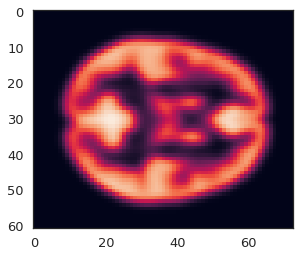

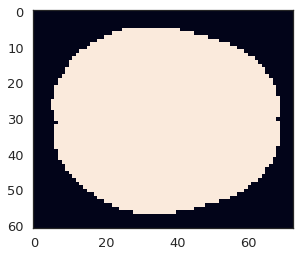

In [7]:
z = 30
plt.imshow(brain_nii.get_data()[:,:,z])
plt.show()
plt.imshow(brain_mask[:,:,z])
plt.show()

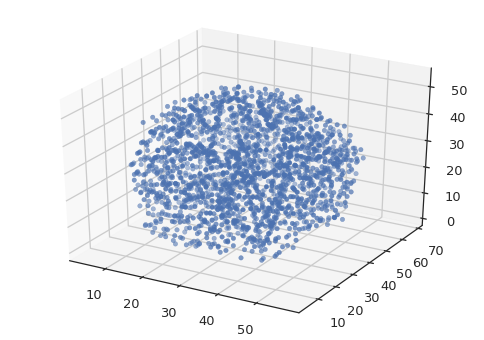

In [8]:
# Solution given in lab

from mpl_toolkits.mplot3d import Axes3D

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111, projection='3d')

skip_val = 50 # plot every other k point for speed

ax.scatter(
    coords[0][0::skip_val], coords[1][0::skip_val], coords[2][0::skip_val],
    marker='o'
)
f.tight_layout()

In [9]:
for key in bold.keys():
    print(key)
    print(bold[key].shape)
    
# Word: 9 subjects, 300 time points, 98508 voxels
# Intact1: 15 subjects, 300 time points, 98508 voxels

# In order to do BOTH spatial and temporal inter subject correlation, 
# need same number of TRs and voxels across all subjects

word
(300, 98508, 9)
intact1
(300, 98508, 15)


### 2.3 Compute ISC <a id="isc_compute"></a>

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data.

In [10]:
# run ISC, loop over conditions 
isc_maps = {}
for task_name in all_task_names:
    isc_maps[task_name] = isc(bold[task_name], pairwise=False)
    print(np.shape(isc_maps[task_name]))

Assuming 9 subjects with 300 time points and 98508 voxel(s) or ROI(s).
(9, 98508)
Assuming 15 subjects with 300 time points and 98508 voxel(s) or ROI(s).
(15, 98508)


The output of ISC is a voxel by participant matrix (since we didn't collapse/average across subjects). Below we will visualize the ISC matrix back on the brain to see where activity is correlated between participants.

In [36]:
# set params 
subj_id = 0
task_name = 'intact1'
save_data = False

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Save the ISC data as a volume
if save_data: 
    isc_map_path = os.path.join(dir_out, 'ISC_%s_sub%.2d.nii.gz' % (task_name, subj_id))
    nib.save(isc_nifti, isc_map_path)

Text(0.5,1,'ISC map for subject 0, task = intact1')

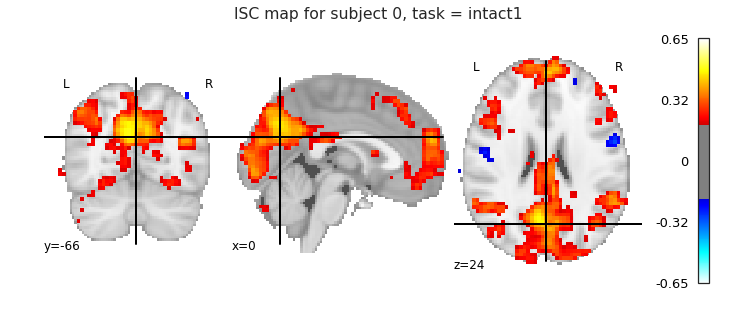

In [37]:
# Plot the data as a statmap
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title(f'ISC map for subject {subj_id}, task = {task_name}') 

**Exercise 2:** <a id="ex2"></a> Visualize the averaged ISC map (averaged across participants) for each task. 
- Make the averaged ISC map for the two conditions (intact, word-scrambled). 
- Visualize them using `plotting.plot_stat_map`. 

*Make sure to compare the two maps using the same xyz cut, threshold and vmax. 

Text(0.5,1,'ISC map for average subject, task = intact1')

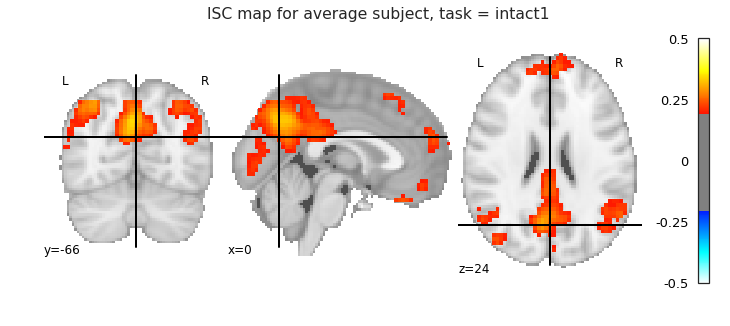

In [42]:
# Insert code here

# set params 
task_name = 'intact1'
num_subj = bold[task_name].shape[2]

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# loop over subjects
for subj_id in range(num_subj):
    isc_vol[coords] = isc_vol[coords] + isc_maps[task_name][subj_id, :]

# average
isc_vol = isc_vol / num_subj
    
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Plot the data as a statmap
threshold = 0.2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax,
    cut_coords = (0, -66, 24),
    vmax=0.5
)
ax.set_title(f'ISC map for average subject, task = {task_name}') 

Text(0.5,1,'ISC map for average subject, task = word')

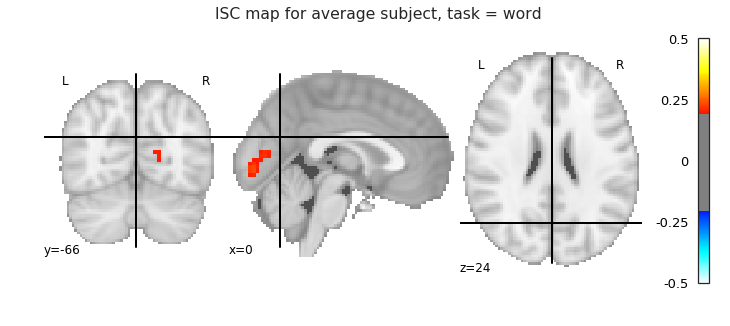

In [41]:
# Insert code here

# set params 
task_name = 'word'
num_subj = bold[task_name].shape[2]

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# loop over subjects
for subj_id in range(num_subj):
    isc_vol[coords] = isc_vol[coords] + isc_maps[task_name][subj_id, :]

# average
isc_vol = isc_vol / num_subj
    
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Plot the data as a statmap
threshold = 0.2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax,
    cut_coords = (0, -66, 24),
    vmax=0.5
)
ax.set_title(f'ISC map for average subject, task = {task_name}') 

#### Surface map 

Here's an example of surface plot. Study the code below.


Dataset created in /home/ttseng/nilearn_data/fsaverage5



Downloaded 270875 of 270875 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 271342 of 271342 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 51949 of 51949 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 270928 of 270928 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 271383 of 271383 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 51997 of 51997 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


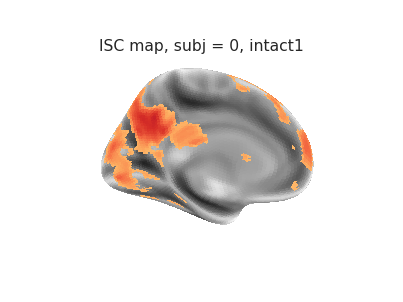

In [21]:
# set some plotting params 
subj_id = 0 
task_name = 'intact1'
threshold = .2 
view = 'medial'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]
# make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# make "texture" 
texture = surface.vol_to_surf(isc_intact_1subj, fsaverage.pial_left) 

# plot 
title_text = f'ISC map, subj = {subj_id}, {task_name}'
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    bg_map=fsaverage.sulc_left)

**Exercise 3:** <a id="ex3"></a> Visualize the averaged ISC map using surface plot. 
- Visualize the average ISC maps using `plotting.plot_surf_stat_map` for:
    - both conditions
    - both `medial` view and `lateral` views 
    
*again, make sure you are using the same threshold and vmax for all plots. 

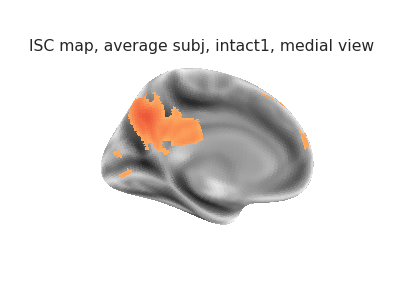

In [47]:
# Insert code here

# set params 
task_name = 'intact1'
num_subj = bold[task_name].shape[2]
threshold = 0.2
vmax = 0.5
view = 'medial'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()
# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# loop over subjects
for subj_id in range(num_subj):
    isc_vol[coords] = isc_vol[coords] + isc_maps[task_name][subj_id, :]

# average
isc_vol = isc_vol / num_subj

# make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# make "texture" 
texture = surface.vol_to_surf(isc_intact_1subj, fsaverage.pial_left) 

# plot 
title_text = f'ISC map, average subj, {task_name}, {view} view'
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    vmax=vmax,
    bg_map=fsaverage.sulc_left)

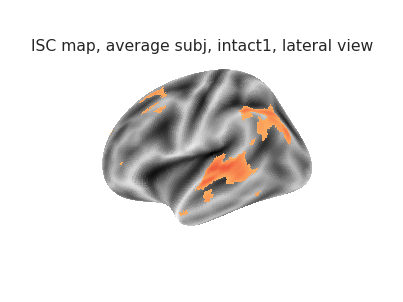

In [48]:
# Insert code here

# set params 
task_name = 'intact1'
num_subj = bold[task_name].shape[2]
threshold = 0.2
vmax = 0.5
view = 'lateral'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()
# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# loop over subjects
for subj_id in range(num_subj):
    isc_vol[coords] = isc_vol[coords] + isc_maps[task_name][subj_id, :]

# average
isc_vol = isc_vol / num_subj

# make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# make "texture" 
texture = surface.vol_to_surf(isc_intact_1subj, fsaverage.pial_left) 

# plot 
title_text = f'ISC map, average subj, {task_name}, {view} view'
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    vmax=vmax,
    bg_map=fsaverage.sulc_left)

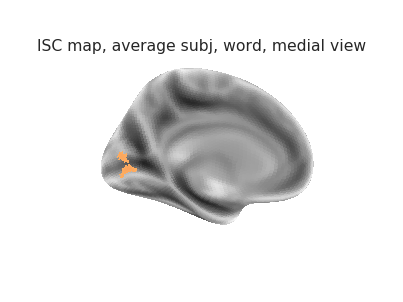

In [49]:
# Insert code here

# set params 
task_name = 'word'
num_subj = bold[task_name].shape[2]
threshold = 0.2
vmax = 0.5
view = 'medial'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()
# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# loop over subjects
for subj_id in range(num_subj):
    isc_vol[coords] = isc_vol[coords] + isc_maps[task_name][subj_id, :]

# average
isc_vol = isc_vol / num_subj

# make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# make "texture" 
texture = surface.vol_to_surf(isc_intact_1subj, fsaverage.pial_left) 

# plot 
title_text = f'ISC map, average subj, {task_name}, {view} view'
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    vmax=vmax,
    bg_map=fsaverage.sulc_left)

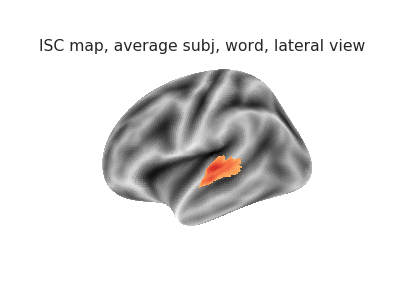

In [50]:
# Insert code here

# set params 
task_name = 'word'
num_subj = bold[task_name].shape[2]
threshold = 0.2
vmax = 0.5
view = 'lateral'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()
# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# loop over subjects
for subj_id in range(num_subj):
    isc_vol[coords] = isc_vol[coords] + isc_maps[task_name][subj_id, :]

# average
isc_vol = isc_vol / num_subj

# make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# make "texture" 
texture = surface.vol_to_surf(isc_intact_1subj, fsaverage.pial_left) 

# plot 
title_text = f'ISC map, average subj, {task_name}, {view} view'
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    vmax=vmax,
    bg_map=fsaverage.sulc_left)

**Exercise 4:** <a id="ex4"></a> Compare the averaged ISC map for the two task conditions. 

- What are some brain regions showing stronger correlation in the intact story condition (vs. the word-level scramble condition)? What's your conclusion? 
Hint: Read the following paper and explain i) what's the point of having a word-level scramble condition; and ii) the idea of "temporal receptive window"
> Lerner, Y., Honey, C. J., Silbert, L. J., & Hasson, U. (2011). Topographic mapping of a hierarchy of temporal receptive windows using a narrated story. The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, 31(8), 2906–2915. https://doi.org/10.1523/JNEUROSCI.3684-10.2011




#### Your answer here: 

The TPJ, IPS, STS, and A regions (the default mode network) show stronger correlation in the intact condition. The word-level scramble slightly decreases the rate of recognition of individual words. A temporal receptive window is the length of time before a response during which sensory information may affect that response. In conclusion, higher-order areas (with stronger correlation in the intact condition) can accumulate information over much longer time windows.

### 2.4 ISC with statistical tests  <a id="isc_stats"></a>

BrainIAK provides several nonparametric statistical tests for ISC analysis. Nonparametric tests are preferred due to the inherent correlation structure across ISC values—each subject contributes to the ISC of other subjects, violating assumptions of independence required for standard parametric tests (e.g., t-test, ANOVA). We will use the permutation test below.

#### 2.4.1 Permutation test
Permutation tests are used to compute a null distribution of values. We have used permutation tests in previous notebooks and the steps outlined here are similar to what was done in prior notebooks with one small change: incorporating the group of subjects to compute the ISC. The following sequence of steps apply to performing a permutation test for ISC:

>1. Prepare the data. Here we have two conditions (intact and word_scramble), so we compute ISC for both conditions and concatenate the data for these two conditions for all subjects.  
>> We use leave-one-subject-out (` pairwise=False`), to compute ISC and we will use these correlations, `isc_maps_all_tasks`, to compute statistics.  
>2. We are going to permute the condition label for each subject to simulate the randomization of conditions. To do this, we first need to assign subjects to the correct experimental conditions that they were in. We have prepared such a list of assignments when we loaded the data and stored the information in the variable: `group_assignment`.
 
>3. The next steps are executed internally in BrainIAK in the function `permutation_isc`. We provide the data and the `group_assignment`.    
>> - For each permutation iteration: 
>>> - BrainIAK permutes the group assignment for each subject.  
>>> - A mean of the ISC values is then computed for this shuffled 
group for each condition.   
>>> -  A difference of group means is computed between each condition.  
>> - This is repeated for each iteration of the permutation test.  
>> - The difference values for all iterations is collected and forms the null distribution.   
>4. Finally, we pick a threshold value that corresponds to `p` percent of this distribution.  


The `permutation_isc` returns the actual observed ISC values, p-values, and optionally the resampling distribution.

#### To learn more about ISC related statistical testing, including a wide variety of statistical tests, please refer to this <a href="https://github.com/snastase/isc-tutorial/blob/master/isc_tutorial.ipynb">ISC tutorial</a> by S. Nastase. 

Reference: Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: nonparametric approaches to inter-subject correlation analysis at the group level. NeuroImage, 142, 248–259. https://doi.org/10.1016/j.neuroimage.2016.05.023

In [7]:
pairwise = False

# concatenate the data 
bold_all_tasks = np.dstack([bold[task_name] for task_name in all_task_names])

# re-compute ISC for all tasks (this will take a while... 
isc_maps_all_tasks = isc(bold_all_tasks, pairwise=pairwise, summary_statistic=None)

print(f'group_assignment: {group_assignment}')
print(f'bold_all_tasks: {np.shape(bold_all_tasks)}')
print(f'isc_maps_all_tasks: {np.shape(isc_maps_all_tasks)}')

Assuming 24 subjects with 300 time points and 98508 voxel(s) or ROI(s).
group_assignment: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
bold_all_tasks: (300, 98508, 24)
isc_maps_all_tasks: (24, 98508)


In [52]:
# permutation testing
n_permutations = 1000
summary_statistic=np.mean

observed, p, distribution = permutation_isc(
    isc_maps_all_tasks, 
    pairwise=pairwise,
    group_assignment=group_assignment, 
    summary_statistic=summary_statistic,
    n_permutations=n_permutations,
    return_distribution=True
)

p = p.ravel()
observed = observed.ravel()

print(f'observed: {np.shape(observed)}')
print(f'p: {np.shape(p)}')
print(f'distribution: {np.shape(distribution)}')

Assuming 24 subjects, 2 group(s), and 98508 voxel(s) or ROI(s).
Two-sample approximate permutation test using group randomization with Monte Carlo resampling.
observed: (98508,)
p: (98508,)
distribution: (1000, 98508)


**Exercise 5:** <a id="ex5"></a> Interpret the results from the permutation test. 

- What's the logic of the permutation test? 
- What are the outputs `observed`, `p`, `distribution` 
- Visualize the correlation contrast map (e.g. intact > word-level scramble) with a significance criterion (e.g. p < .005). Which region(s) showed higher ISC under the chosen contrast? 

#### your answer here: 

The permutation test randomly permutes label assignments to construct a null distribution by calculating all posssible test value statistics under rearrangements of these labels. It then gets the 5% significance level from this null distribution to see whether the computed p statistic is significant at this level or not.

observed is the ISC values for the voxels. p is the p-values from the two-tailed permutation test. distribution is the null permutation distribution.

In [98]:
# Insert code here
sig = 0.005
idx = np.argwhere(p < sig)

# 0 out the indices where p is not < sig
to_plot = observed.copy()
to_plot[[i for i in range(len(to_plot)) if i not in idx]] = 0

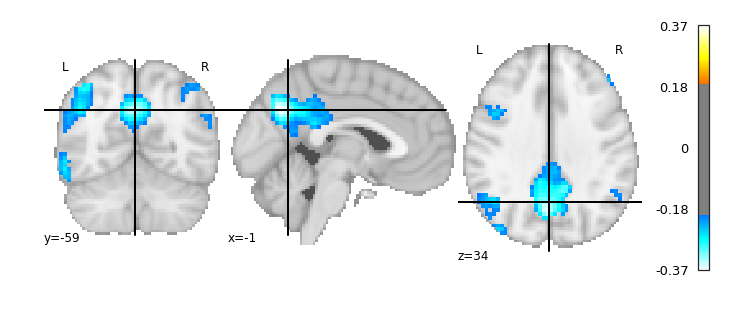

In [100]:
# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = to_plot
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Plot the data as a statmap
threshold = 0.2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax,
    #cut_coords = (0, -66, 24),
    #vmax=0.5
)

## 3 ISFC  <a id="isfc"></a>

The goal of ISFC is to find coupling between brain regions across subjects.
For example the angular gyrus in subject 1 can be correlated to the pre-frontal cortex in subject 2, only because they share some cognitive state. For completely random congnitive states across these two subjects, the correlation should be zero. ISFC helps us identify such commonanlities across subjects.

In this section, we will compare FC vs. ISFC on the pieman data. At the end of the exercises, you will qualitatively replicate [Simony et al., 2016](https://doi.org/10.1038/ncomms12141), showing that ISFC is sensitive to the cognitive state of the subjects.

### 3.1 Parcel the data  <a id="isfc_parcel"></a>


ISFC in the voxel space is very computationally intensive -- if we have $V$ voxels, then its computational complexity has a multiplicative $V^2$ term, and typically $V$ is on the order of $10^3$ or $10^4$. For this lab, we parcellate $V$ voxels to a small number of parcels (on the order of $10^1$ or $10^2$, typically). 

You can use some predefined ROI masks, if you don't want to do whole-brain analysis.

number of voxels:	 98508
number of parcels:	 48


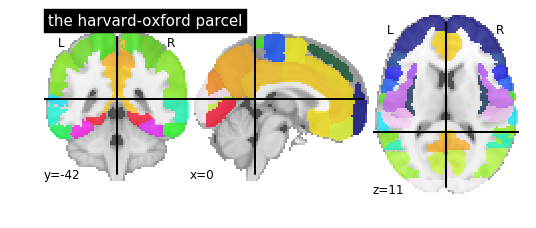

In [60]:
# load a parcel
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
plotting.plot_roi(atlas.maps, title='the harvard-oxford parcel')

n_regions = len(atlas.labels)-1 # rm background region 
n_TRs = np.shape(bold[task_name])[0]

print(f'number of voxels:\t {np.shape(bold[task_name])[1]}')
print(f'number of parcels:\t {n_regions}')

In [61]:
# get a masker for the atlas 
masker_ho = NiftiLabelsMasker(labels_img=atlas.maps)

# transform the data to the parcel space
bold_ho = {
    task_name:np.zeros((n_TRs, n_regions, n_subjs[task_name])) 
    for task_name in all_task_names}
# collect all data 
row_has_nan = np.zeros(shape=(n_regions,), dtype=bool)
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        # get the data for task t, subject s 
        nii_t_s = nib.load(fnames[task_name][subj_id])
        bold_ho[task_name][:,:,subj_id] = masker_ho.fit_transform(nii_t_s)
        # figure out missing rois
        row_has_nan_ = np.any(np.isnan(bold_ho[task_name][:,:,subj_id]),axis=0)
        row_has_nan[row_has_nan_] = True                

# figure out which ROI has missing values
roi_select = np.logical_not(row_has_nan)
n_roi_select = np.sum(roi_select)
rois_filtered = np.array(atlas.labels[1:])[roi_select]
bold_ho_filtered = {
    task_name:np.zeros((n_TRs, n_roi_select, n_subjs[task_name])) 
    for task_name in all_task_names
}
# remove ROIs with missing values
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        bold_ho_filtered[task_name][:,:,subj_id] = bold_ho[task_name][:,roi_select,subj_id]
              
print(f'ROI selected\n{rois_filtered}\n')
print(f'ROI removed due to missing values :( \n{np.array(atlas.labels[1:])[row_has_nan]}')

ROI selected
['Insular Cortex' 'Inferior Frontal Gyrus, pars triangularis'
 'Inferior Frontal Gyrus, pars opercularis'
 'Superior Temporal Gyrus, anterior division'
 'Superior Temporal Gyrus, posterior division'
 'Middle Temporal Gyrus, anterior division'
 'Middle Temporal Gyrus, posterior division'
 'Middle Temporal Gyrus, temporooccipital part'
 'Inferior Temporal Gyrus, temporooccipital part'
 'Supramarginal Gyrus, anterior division'
 'Lateral Occipital Cortex, inferior division' 'Intracalcarine Cortex'
 'Frontal Medial Cortex' 'Subcallosal Cortex' 'Paracingulate Gyrus'
 'Cingulate Gyrus, anterior division'
 'Cingulate Gyrus, posterior division' 'Cuneal Cortex'
 'Frontal Orbital Cortex' 'Parahippocampal Gyrus, anterior division'
 'Parahippocampal Gyrus, posterior division' 'Lingual Gyrus'
 'Temporal Occipital Fusiform Cortex' 'Occipital Fusiform Gyrus'
 'Frontal Operculum Cortex' 'Central Opercular Cortex'
 'Parietal Operculum Cortex' 'Planum Polare'
 "Heschl's Gyrus (includes H1 an

### 3.2 Compute FC and ISFC  <a id="fc_isfc"></a>

Here we compute FC and ISFC on the parcellated data. 

In [62]:
# compute FC
fc_maps = {
    task_name:np.zeros((n_roi_select,n_roi_select)) 
    for task_name in all_task_names
}
for task_name in all_task_names: 
    for subj_id in range(n_subjs[task_name]): 
        fc_maps[task_name] += np.corrcoef(
            bold_ho_filtered[task_name][:,:,subj_id].T
        ) / n_subjs[task_name]
        np.fill_diagonal(fc_maps[task_name], np.nan)
        
# compute ISFC
isfc_maps_ho = {}
for task_name in all_task_names: 
    isfc_maps_ho[task_name] = isfc(data=bold_ho_filtered[task_name], summary_statistic=np.median)        

Assuming 9 subjects with 300 time points and 31 voxel(s) or ROI(s).
Assuming 15 subjects with 300 time points and 31 voxel(s) or ROI(s).


**Exercise 6:** <a id="ex6"></a> Visualize the FC/ISFC matrices, averaged across subjects

- Use `imshow` to visualize the 4 correlation matrices: (FC vs. ISFC) x (word-level scrabled vs. intact story)
- Mark the rows (or columns) with the ROI labels

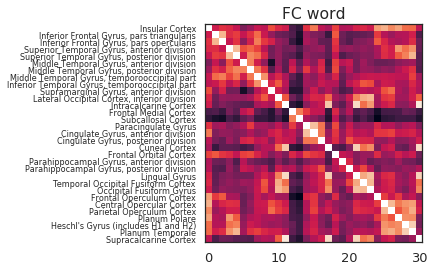

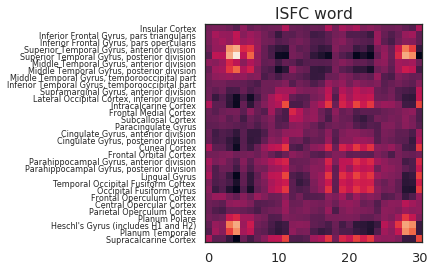

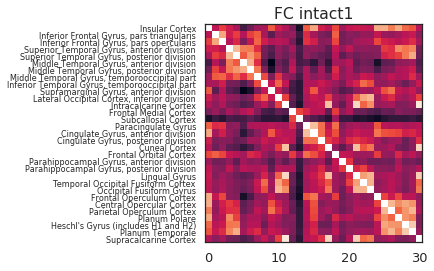

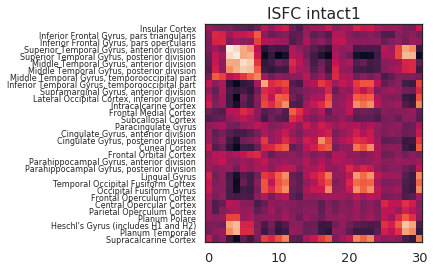

In [106]:
# Insert code here
for task_name in all_task_names:
    plt.imshow(fc_maps[task_name])
    plt.title('FC {}'.format(task_name))
    plt.yticks(range(len(rois_filtered)), rois_filtered, fontsize=8)
    plt.show()
    plt.imshow(isfc_maps_ho[task_name])
    plt.title('ISFC {}'.format(task_name))
    plt.yticks(range(len(rois_filtered)), rois_filtered, fontsize=8)
    plt.show()

**Exercise 7:** <a id="ex7"></a> Visualize FC/ISFC connectivity strength on glass brains 

- Use `plot_connectome` to visualize the 4 correlation matrices: (FC vs. ISFC) x (word-level scrabled vs. intact story)
- Use common `edge_threshold` for all plots. 

In [112]:
# Load the atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps
atlas_nii = nib.load(atlas_filename)
atlas_data = atlas_nii.get_data()
labels = np.unique(atlas_data)

# Iterate through all of the ROIs that we selected
roi_coords = []
for label_id in labels[1:][roi_select]:
        
    # Pull out the ROI of within the mask    
    roi_mask = (atlas_data == label_id)
    
    # Create as a nifti object so it can be read by the cut coords algorithm
    nii = nib.Nifti1Image(roi_mask.astype('int16'), atlas_nii.affine)
    
    # Find the centre of mass of the connectome
    roi_coords.append(plotting.find_xyz_cut_coords(nii))

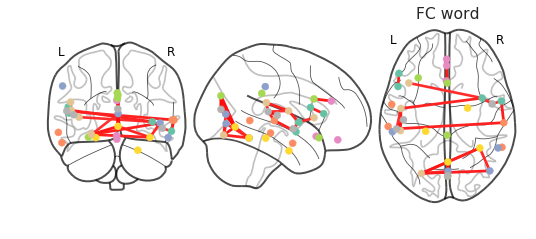

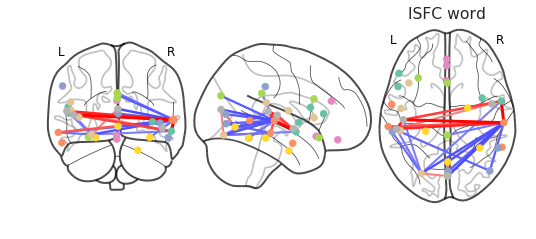

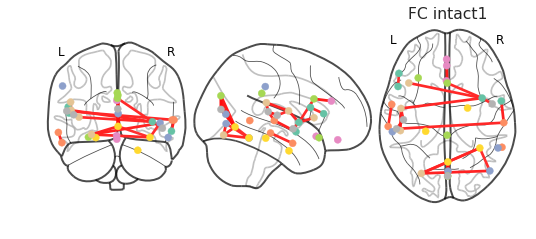

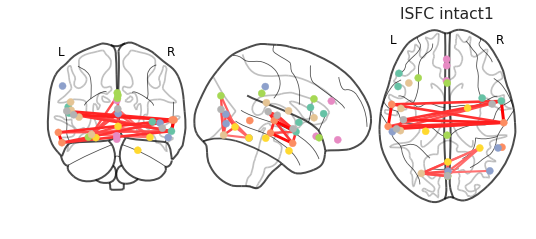

In [115]:
# Insert code here
for task_name in all_task_names:
    plotting.plot_connectome(fc_maps[task_name], roi_coords, edge_threshold='95%')
    plt.title('FC {}'.format(task_name))
    plt.show()
    plotting.plot_connectome(isfc_maps_ho[task_name], roi_coords, edge_threshold='95%')
    plt.title('ISFC {}'.format(task_name))
    plt.show()

**Exercise 8:** <a id="ex8"></a> Do FC maps look different across conditions? How about ISFC? And why? 


*[Hint] Read this paper: Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016). Dynamic reconfiguration of the default mode network during narrative comprehension. Nature Communications, 7, 12141. https://doi.org/10.1038/ncomms12141

#### Your response here: 

The FC maps look fairly similar across conditions, but ISFC maps look different because we are able to remove noise associated with certain participants/scanner error/etc. as ISFC isolates stimuli that are common across subjects. Simony et al. were able to isolate DMN correlation patterns associated with narrative segment processing.

## 4 Spatial pattern correlation across subjects


### 4.1 Spatial inter-subject correlation  <a id="spatial_isc"></a>

<br>
We can apply the idea of inter-subject analysis to RSA. 
So far, ISC being computed between aligned pairs of voxels across time points and it is commonly referred as temporal ISC. However, we could instead correlate between aligned pairs of time points across voxels. That is, how does the pattern of activity across voxels for one time point correlates with the average pattern of the other participants at that time point. By doing this for each time point, we can generate a time course of these correlations to observe the general ebb and flow of coupling in brain activity across participants. This can be done simply by transposing the voxel and time dimensions (for a 3-D matrix, this is accomplished with a 90 degree rotation). The <a href= https://lihan.me/2018/01/numpy-reshape-and-transpose/ >numpy.transpose</a> method is useful for this. If we have data in the format:
(TRs, voxels, subjects), we can use data.transpose(1,0,2), where the indices refer to the dimensions of the array and we will have an array in the format (voxels, TRs, subjects).

We could also average across time-points to compute spatial ISC for events <a href= https://www.nature.com/articles/nn.4450>(Chen et al., (2017)).</a> In this case, we make an average of the TRs for each event. We then transpose this matrix by making the time value as the first dimension of the array. The ISC function will then compute the spatial ISC for each event.

Reference: 

- Chen, J., Leong, Y. C., Honey, C. J., Yong, C. H., Norman, K. A., & Hasson, U. (2017). Shared memories reveal shared structure in neural activity across individuals. Nature Neuroscience, 20, 115–125. https://doi.org/10.1038/nn.4450

#### Compare the two task conditions by spatial ISC 

One way to compare the intact and word_scramble conditions is to plot the correlation values, by TR, for each condition. Again, we can simply use isc functions to compute pattern correlation by transposing the data matrices. 

Get a list of ROIs. 

In [21]:
roi_mask_path = os.path.join(pieman2_dir,'masks','rois')
all_roi_fpaths = glob.glob(os.path.join(roi_mask_path, '*.nii'))

# collect all ROIs 
all_roi_names = []
all_roi_nii = {}
all_roi_masker = {}
for roi_fpath in all_roi_fpaths: 
    # compute ROI name
    roi_fname = os.path.basename(roi_fpath)
    roi_name = roi_fname.split('.')[0]
    all_roi_names.append(roi_name)
    # load roi nii file 
    roi_nii = nib.load(roi_fpath)
    all_roi_nii[roi_name] = roi_nii
    # make roi maskers
    all_roi_masker[roi_name] = NiftiMasker(mask_img=roi_nii)

print(f'Path to all roi masks: {roi_mask_path}')    
print(f'Here are all ROIs:\n{all_roi_names}')

Path to all roi masks: /home/NEU480/datasets/Pieman2/masks/rois
Here are all ROIs:
['aANG_L', 'aANG_R', 'aCUN', 'aIFG_L', 'aIFG_R', 'aINS_L', 'aMTG_R', 'aOFC_L', 'aOFC_R', 'aPFC', 'aSTG_L', 'caMTG_L', 'cMTG_R', 'DLPFC_L', 'DLPFC_R', 'dMFG_L', 'dMFG_R', 'dmPFG', 'dPCC', 'dPCUN', 'dPoCS_L', 'dPoCS_R', 'dPreCG_L', 'HG_L', 'HG_R', 'hV4_L', 'hV4_R', 'Insular_L', 'Insular_R', 'IPL_L', 'IPL_R', 'ldV2_L', 'LOC_L', 'LOC_R', 'lOFG_L', 'lOFG_R', 'MCC', 'mldV2_R', 'pANG_L', 'pANG_R', 'pIFG_L', 'PMC_L', 'pMTG_R', 'pMTS_L', 'pMTS_R', 'SFG', 'SFS_L', 'SMA_L', 'SMG_L', 'SMG_R', 'smPFC', 'SOG_L', 'STC_L', 'STC_R', 'V1', 'V3a_L', 'V3a_R', 'V3', 'vMFG_L', 'vmPFC', 'vPCUN', 'vPFC_R', 'vV2']


In [22]:
# helper funcs - load data for one roi
def load_roi_data(roi_name): 
    # pick a roi masker
    roi_masker = all_roi_masker[roi_name]    
    
    # preallocate 
    bold_roi = {task_name:[] for i, task_name in enumerate(all_task_names)}
    # gather data 
    for task_name in all_task_names:
        for subj_id in range(n_subjs[task_name]):
            # get the data for task t, subject s 
            nii_t_s = nib.load(fnames[task_name][subj_id])
            bold_roi[task_name].append(roi_masker.fit_transform(nii_t_s))
        # reformat the data to std form 
        bold_roi[task_name] = np.transpose(np.array(bold_roi[task_name]), [1,2,0])
    return bold_roi

Compute spatial ISC on some ROIs. 

In [23]:
roi_selected = ['dPCC', 'vPCUN']
roi_selected_names = ['dorsal posterior cingulate cortex', 'ventral precuneus']

# compute sISC for all ROIs 
iscs_roi_selected = []
for j, roi_name in enumerate(roi_selected):
    print(j, roi_name)
    # load data 
    bold_roi = load_roi_data(roi_name)
    # compute isc 
    iscs_roi = {}
    for task_name in all_task_names: 
        iscs_roi[task_name] = isc(np.transpose(bold_roi[task_name], [1,0,2]), verbose=False)
    iscs_roi_selected.append(iscs_roi)

0 dPCC
1 vPCUN


Here's the result! For dorsal posterior cingulate cortex (dPCC) and ventral precuneus (vPCUN), we can see that word-level scrambling reduces spatial ISC. 

**Self study**: Do some research to find out ... 
- Where are these two ROIs? 
- Why might word-level scrambling reduce their spatial ISC? 

Text(0.5,0,'TRs')

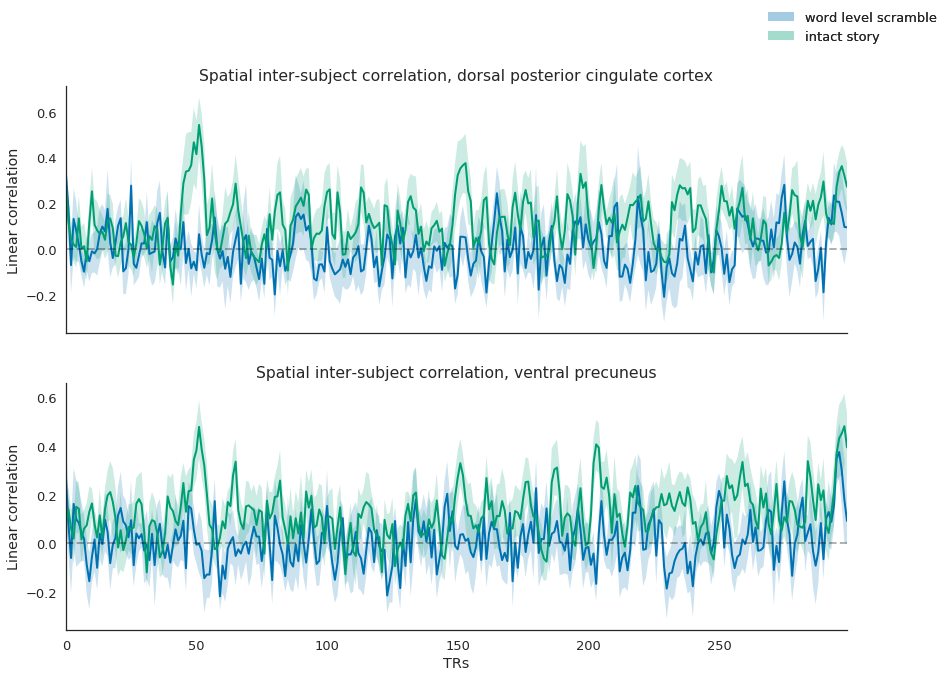

In [24]:
# plot the spatial ISC over time
col_pal = sns.color_palette(palette='colorblind', n_colors=len(all_task_names))
ci = 95

f, axes = plt.subplots(len(roi_selected), 1, figsize=(14, 5 * len(roi_selected)), sharex=True)

# for each ROI
for j, roi_name in enumerate(roi_selected):
    # for each task 
    for i, task_name in enumerate(all_task_names): 
        sns.tsplot(
            iscs_roi_selected[j][task_name], 
            color=col_pal[i], ci=ci, 
            ax=axes[j]
        )
    f.legend(all_task_des)
    sns.despine()

# label the plot 
for j, roi_name in enumerate(roi_selected):
    axes[j].axhline(0, color='black', linestyle='--', alpha=.3)
    axes[j].set_ylabel('Linear correlation')
    axes[j].set_title(f'Spatial inter-subject correlation, {roi_selected_names[j]}')
    
axes[-1].set_xlabel('TRs')

**Novel contribution:**<a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

Here're some ideas: 

- `isc_standalone.py` supports other statistical tests. Study one them, describe the logic behind it, and re-run the analysis with that test. 
    - To learn more about ISC related statistical testing, please refer to this <a href="https://github.com/snastase/isc-tutorial/blob/master/isc_tutorial.ipynb">ISC tutorial</a> by S. Nastase. 
    - For phase randomization, see Lerner et al. (2011) and Simony et al. (2016). 
    - For the bootstrap test, see Chen et al. (2016).
    - For circular time shift, see Kauppi et al. (2014). 
- Conduct a sliding window spatial ISC analysis. 
    - See Chen et al. (2017) and Zadbood et al. (2017). 
- Compare FC vs. ISFC using using the ROI masks (instead of the parcel). 
    - For the choice of ROIs, please refer to Simony et al 2016. 
- Perform some clustering on the ISFC matrices. Use the clustering (instead of the anatomical parcel) to re-analyze the data, and compare ISFC vs. FC across tasks. Be sure to describe the clustering procedure you are using (e.g. What's the objective function? What's the assumption of the clustering optimization?)
    - A good resource for clustering algorithms is the [scikit-learn clustering module](http://scikit-learn.org/stable/modules/clustering.html). 




References: 

- Chen, J., Leong, Y. C., Honey, C. J., Yong, C. H., Norman, K. A., & Hasson, U. (2017). Shared memories reveal shared structure in neural activity across individuals. Nature Neuroscience, 20, 115–125. https://doi.org/10.1038/nn.4450

- Kauppi, J. P., Pajula, J., & Tohka, J. (2014). A versatile software package for inter-subject correlation based analyses of fMRI. Frontiers in Neuroinformatics, 8, 2. https://doi.org/10.3389/fninf.2014.00002

- Lerner, Y., Honey, C. J., Silbert, L. J., & Hasson, U. (2011). Topographic mapping of a hierarchy of temporal receptive windows using a narrated story. The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, 31(8), 2906–2915. https://doi.org/10.1523/JNEUROSCI.3684-10.2011

- Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016). Dynamic reconfiguration of the default mode network during narrative comprehension. Nature Communications, 7, 12141. https://doi.org/10.1038/ncomms12141

- Zadbood, A., Chen, J., Leong, Y. C., Norman, K. A., & Hasson, U. (2017). How we transmit memories to other brains: constructing shared neural representations via communication. Cerebral Cortex, 27(10), 4988–5000. https://doi.org/10.1093/cercor/bhx202

**Novel contribution**: Explore bootstrap_isc statistical test and re-run analysis.

This is similar in spirit to the permutation test in that it uses randomization to compute actual ISC and p-values from a null distribution. Instead of permuting group assignment labels, the bootstrap randomly resamples subject with replacement.

In [8]:
from isc_standalone import bootstrap_isc

In [11]:
# circular timeshift testing'
pairwise=False
n_bootstraps = 1000
summary_statistic=np.mean

observed, ci, p, distribution = bootstrap_isc(
    isc_maps_all_tasks, 
    pairwise=pairwise,
    summary_statistic=summary_statistic,
    n_bootstraps=n_bootstraps,
    return_distribution=True
)

p = p.ravel()
observed = observed.ravel()

print(f'observed: {np.shape(observed)}')
print(f'p: {np.shape(p)}')
print(f'distribution: {np.shape(distribution)}')

Assuming 24 subjects with and 98508 voxel(s) or ROI(s).
observed: (98508,)
p: (98508,)
distribution: (1000, 98508)


In [14]:
sig = 0.005
idx = np.argwhere(p < sig)

# 0 out the indices where p is not < sig
to_plot = observed.copy()
to_plot[[i for i in range(len(to_plot)) if i not in idx]] = 0

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = to_plot
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

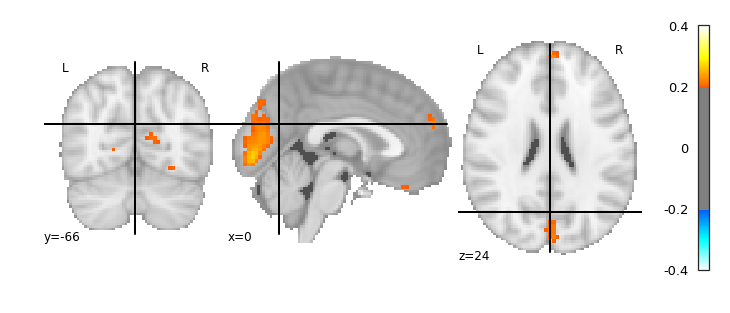

In [16]:
# Plot the data as a statmap
threshold = 0.2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax,
    cut_coords = (0, -66, 24),
    vmax=0.4
)

### Contributions<a id="contributions"></a>

E. Simony and U. Hasson for providing data  
C. Baldassano and C. Chen provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
S. Nastase enhanced the ISC brainiak module; added the section on statistical testing   
Q. Lu added solutions; switched to S. Nastase's ISC module; replicated Lerner et al 2011 & Simony et al. 2016; added spatial ISC.   
M. Kumar edits to section introductions and explanation on permutation test.